In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils


from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

> https://www.kaggle.com/datasets/paultimothymooney/blood-cells

In [2]:
##### Colab

ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cell")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST_SIMPLE")

In [4]:
##### Colab
from google.colab import drive

drive.mount("/content/gdrive/")

shutil.copy(os.path.join("/content/gdrive/MyDrive/acorn", "blood_cell.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cell.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
##### remove blood_cell in blood_cell
source_dir = '/content/blood_cell/blood_cell'
target_dir = '/content/blood_cell'

# Get a list of directories in the source directory
directories = next(os.walk(source_dir))[1]

# Move each directory to the target directory
for directory in directories:
    source_path = os.path.join(source_dir, directory)
    target_path = os.path.join(target_dir, directory)
    shutil.move(source_path, target_path)

directory_to_remove = '/content/blood_cell/blood_cell'

# Remove the directory and its contents
shutil.rmtree(directory_to_remove)

In [7]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))


test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))


test_simple_label_name_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(test_simple_label_name_list)

for label_name in test_simple_label_name_list:
    print("val label :", label_name, " => ", len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name))))

['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : MONOCYTE  =>  2478
test label : NEUTROPHIL  =>  2499
test label : LYMPHOCYTE  =>  2483
test label : EOSINOPHIL  =>  2497
['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : MONOCYTE  =>  620
test label : NEUTROPHIL  =>  624
test label : LYMPHOCYTE  =>  620
test label : EOSINOPHIL  =>  623
['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']
val label : MONOCYTE  =>  4
val label : NEUTROPHIL  =>  48
val label : LYMPHOCYTE  =>  6
val label : EOSINOPHIL  =>  13


In [9]:
##### Let's shuffle

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']


In [10]:
##### Move to TRAIN at all files in TEST
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST => Train)")

620 is moved into MONOCYTE(TEST => Train)
624 is moved into NEUTROPHIL(TEST => Train)
620 is moved into LYMPHOCYTE(TEST => Train)
623 is moved into EOSINOPHIL(TEST => Train)


In [11]:
##### Move to TRAIN all files in TEST_SIMPLE
for label_name in test_simple_label_name_list:
    test_simple_path = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)
    test_simple_file_list = os.listdir(test_simple_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_simple_file in test_simple_file_list:
        shutil.move(os.path.join(test_simple_path, test_simple_file),
                   os.path.join(train_path, test_simple_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST_SIMPLE => Train)")

4 is moved into MONOCYTE(TEST_SIMPLE => Train)
48 is moved into NEUTROPHIL(TEST_SIMPLE => Train)
6 is moved into LYMPHOCYTE(TEST_SIMPLE => Train)
13 is moved into EOSINOPHIL(TEST_SIMPLE => Train)


In [12]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : MONOCYTE  =>  3095
test label : NEUTROPHIL  =>  3171
test label : LYMPHOCYTE  =>  3108
test label : EOSINOPHIL  =>  3133


In [13]:

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src)

    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split num => ", split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1

    print("total move num => ", move_num)
    print("=============================================")

total [MONOCYTE] data file nums => [3095]
train data shuffle is done!
split num =>  619
total move num =>  619
total [NEUTROPHIL] data file nums => [3171]
train data shuffle is done!
split num =>  634
total move num =>  634
total [LYMPHOCYTE] data file nums => [3108]
train data shuffle is done!
split num =>  621
total move num =>  621
total [EOSINOPHIL] data file nums => [3133]
train data shuffle is done!
split num =>  626
total move num =>  626


In [14]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : MONOCYTE  =>  2476
test label : NEUTROPHIL  =>  2537
test label : LYMPHOCYTE  =>  2487
test label : EOSINOPHIL  =>  2507
['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']
test label : MONOCYTE  =>  619
test label : NEUTROPHIL  =>  634
test label : LYMPHOCYTE  =>  621
test label : EOSINOPHIL  =>  626


Found 8007 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2500 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4
(16, 224, 224, 3) (16,)
[1. 3. 1. 0. 0. 3. 3. 2. 1. 1. 3. 3. 2. 1. 0. 0.]
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                

251/251 [==============================] - 89s 206ms/step - loss: 1.4800 - acc: 0.2857 - val_loss: 1.9404 - val_acc: 0.2485
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 1.1518 - acc: 0.4606
Epoch 2: val_loss did not improve from 1.94043
251/251 [==============================] - 21s 83ms/step - loss: 1.1518 - acc: 0.4606 - val_loss: 3.9860 - val_acc: 0.2505
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.8356 - acc: 0.6448
Epoch 3: val_loss improved from 1.94043 to 1.49781, saving model to content/


251/251 [==============================] - 49s 197ms/step - loss: 0.8356 - acc: 0.6448 - val_loss: 1.4978 - val_acc: 0.2510
Epoch 4/20
251/251 [==============================] - ETA: 0s - loss: 0.6460 - acc: 0.7349
Epoch 4: val_loss improved from 1.49781 to 0.76562, saving model to content/


251/251 [==============================] - 50s 198ms/step - loss: 0.6460 - acc: 0.7349 - val_loss: 0.7656 - val_acc: 0.7780
Epoch 5/20
251/251 [==============================] - ETA: 0s - loss: 0.5603 - acc: 0.7807
Epoch 5: val_loss improved from 0.76562 to 0.18117, saving model to content/


251/251 [==============================] - 50s 197ms/step - loss: 0.5603 - acc: 0.7807 - val_loss: 0.1812 - val_acc: 0.9580
Epoch 6/20
251/251 [==============================] - ETA: 0s - loss: 0.4744 - acc: 0.8162
Epoch 6: val_loss improved from 0.18117 to 0.13181, saving model to content/


251/251 [==============================] - 49s 197ms/step - loss: 0.4744 - acc: 0.8162 - val_loss: 0.1318 - val_acc: 0.9615
Epoch 7/20
251/251 [==============================] - ETA: 0s - loss: 0.4031 - acc: 0.8460
Epoch 7: val_loss improved from 0.13181 to 0.08184, saving model to content/


251/251 [==============================] - 49s 197ms/step - loss: 0.4031 - acc: 0.8460 - val_loss: 0.0818 - val_acc: 0.9755
Epoch 8/20
251/251 [==============================] - ETA: 0s - loss: 0.3476 - acc: 0.8657
Epoch 8: val_loss improved from 0.08184 to 0.05225, saving model to content/


251/251 [==============================] - 49s 197ms/step - loss: 0.3476 - acc: 0.8657 - val_loss: 0.0522 - val_acc: 0.9845
Epoch 9/20
251/251 [==============================] - ETA: 0s - loss: 0.3280 - acc: 0.8735
Epoch 9: val_loss did not improve from 0.05225
251/251 [==============================] - 21s 84ms/step - loss: 0.3280 - acc: 0.8735 - val_loss: 0.0876 - val_acc: 0.9770
Epoch 10/20
251/251 [==============================] - ETA: 0s - loss: 0.2942 - acc: 0.8863
Epoch 10: val_loss improved from 0.05225 to 0.03633, saving model to content/


251/251 [==============================] - 50s 199ms/step - loss: 0.2942 - acc: 0.8863 - val_loss: 0.0363 - val_acc: 0.9900
Epoch 11/20
251/251 [==============================] - ETA: 0s - loss: 0.2584 - acc: 0.9028
Epoch 11: val_loss did not improve from 0.03633
251/251 [==============================] - 21s 83ms/step - loss: 0.2584 - acc: 0.9028 - val_loss: 0.0378 - val_acc: 0.9910
Epoch 12/20
251/251 [==============================] - ETA: 0s - loss: 0.2476 - acc: 0.9062
Epoch 12: val_loss did not improve from 0.03633
251/251 [==============================] - 21s 84ms/step - loss: 0.2476 - acc: 0.9062 - val_loss: 0.0430 - val_acc: 0.9890
Epoch 13/20
251/251 [==============================] - ETA: 0s - loss: 0.2268 - acc: 0.9138
Epoch 13: val_loss did not improve from 0.03633
251/251 [==============================] - 21s 83ms/step - loss: 0.2268 - acc: 0.9138 - val_loss: 0.0425 - val_acc: 0.9920
Epoch 14/20
251/251 [==============================] - ETA: 0s - loss: 0.2015 - acc: 0.

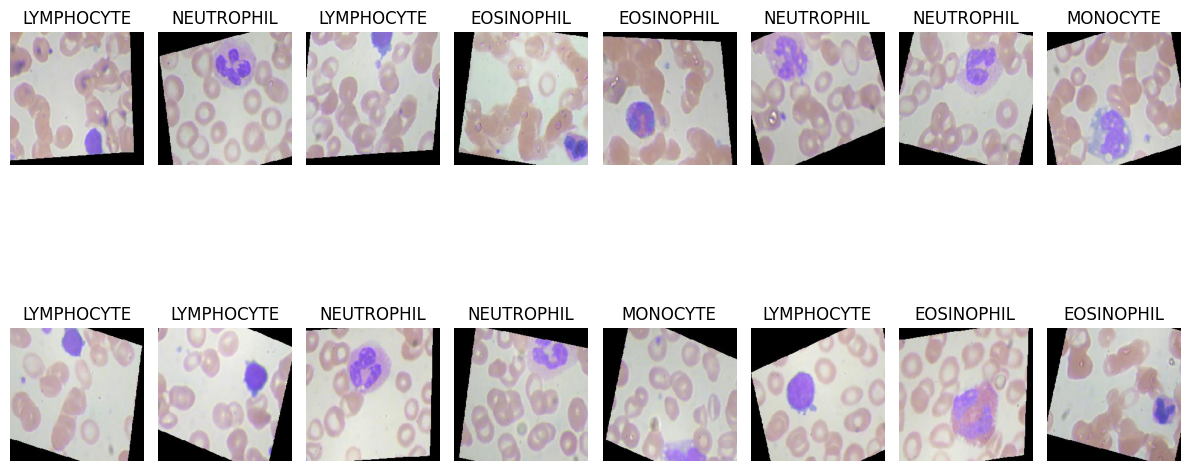

In [16]:
IMG_WIDTH = 224
IMG_HEIGHT = 224


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)
test_simple_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="training")

val_generator = validation_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="validation")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")
test_simple_generator = test_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

print(train_generator.class_indices)
print(train_generator.num_classes)

data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'EOSINOPHIL', 1 : 'LYMPHOCYTE', 2 : 'MONOCYTE', 3 : 'NEUTROPHIL'}


for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

pre_trained_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(2e-5), metrics=["acc"]) # 2e-5

start_time = datetime.now()

save_file_name = 'content/'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

result = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

63/63 [==============================] - 4s 66ms/step - loss: 0.0537 - acc: 0.9880


[0.05372240021824837, 0.9879999756813049]

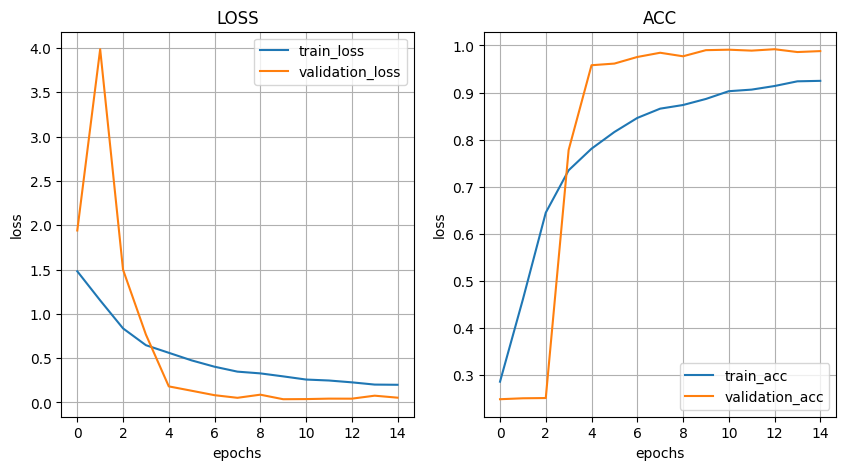

In [18]:
# include_top = False
# ResNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")

model.evaluate(val_generator)